In [117]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [104]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [118]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect,func 

In [119]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [120]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [121]:
# View all of the classes that automap found
#Base.classes.keys()
Base.classes.keys()
#inspector=inspector(engine)
inspector = inspect(engine)

In [122]:
inspector.get_table_names()

['measurement', 'station']

In [123]:
# Save references  each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [124]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [125]:
Columns=inspector.get_columns('Measurement')
for column in Columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [126]:
#for measurement in Measurement:
for prec in session.query(Measurement.id, Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).limit(5).all():
        print(prec)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


# Exploratory Precipitation Analysis

In [127]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [128]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_12_month = dt.date(2017,8,23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
Precipitation_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_month ).all()


In [129]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(Precipitation_score, columns=['date','precipitation'])

# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by='date').dropna()
prcp_df.head(5)

,date,precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70


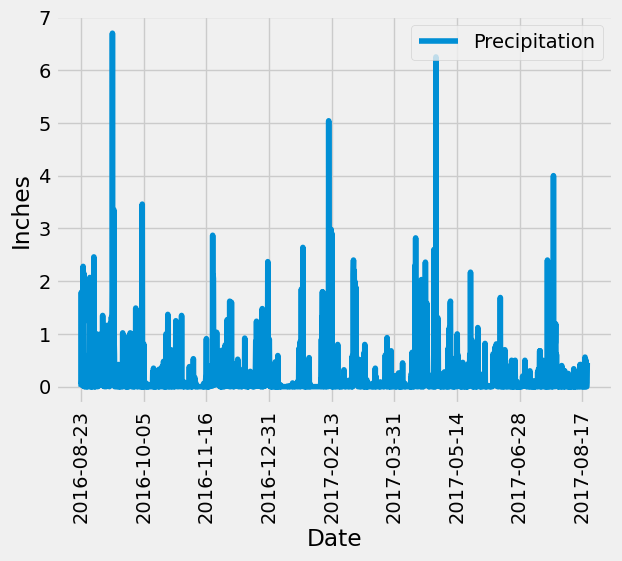

In [130]:
# Use Pandas Plotting with Matplotlib to plot the data 
prcp_df.plot('date','precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

plt.xticks(rotation='vertical')
plt.legend(['Precipitation'], loc='upper right')

plt.show()



In [131]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [134]:
# explore the data
Columns=inspector.get_columns('Station')
for column in Columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [137]:
# for station in Station
for station in session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).limit(5).all():
    print(station)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [143]:
# Design a query to calculate the total number stations in the dataset
stations_count=session.query(Station.id).count()
print(f'Total number of stations are {stations_count}')

Total number of stations are 9


In [189]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.id, Measurement.station,  func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[(12188, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2725, 'USC00513117', 2709),
 (9519, 'USC00519523', 2669),
 (16939, 'USC00516128', 2612),
 (5434, 'USC00514830', 2202),
 (14960, 'USC00511918', 1979),
 (7636, 'USC00517948', 1372),
 (9008, 'USC00518838', 511)]

In [194]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#First query the station id using the station name
#session.query(Station.id,Measurement.station).filter(Measurement.station=='USC00519281').group_by(Station.name).all()
session.query(Station.id).filter(Station.station=='USC00519281').group_by(Station.name).all()

[(7,)]

In [193]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count().desc()).\
        first()

(most_active_station_id, ) = most_active_station
print(f"The station id of the most active station is {most_active_station_id}.")

most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station_id) .\
        all()

for lowest_temp, highest_temp, avg_temp in most_active_station:
    print(f"The lowest temperature recorded at {most_active_station_id} is {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} is {highest_temp}.")
    print(f"The average temperature recorded at {most_active_station_id} is {avg_temp}.")
    



The station id of the most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


In [ ]:
 # Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [197]:
# Find the most recent date in the data set.
measurement_tuple = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_station_id).first()


In [198]:
# Find year ago date in the data set.
(latest_date,) = measurement_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)



In [203]:
# Query the last 12 months of temperature observation data
last_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= date_year_ago).all()
    
last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])
last_year_data_df.head()

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


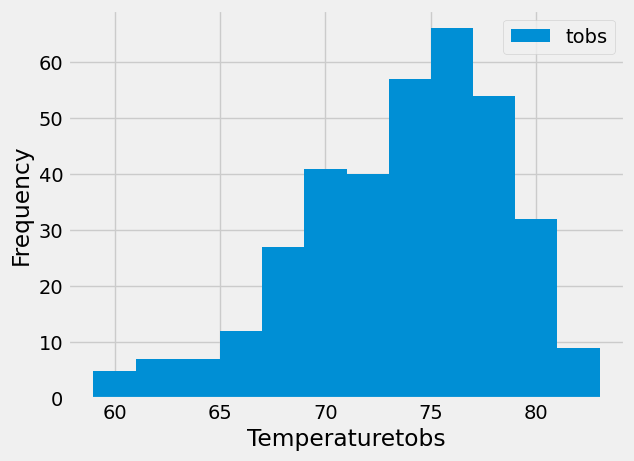

In [205]:
#plot the results as a histogram
plt.hist(last_year_data_df["tobs"], bins=12, label="tobs")
plt.ylabel('Frequency')
plt.xlabel('Temperaturetobs')
plt.grid(zorder=0)
plt.legend(loc="upper right")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()